# Financial analytics of S&P 500 and the VIX

## Gathering the data

In [1]:
from alpha_vantage.timeseries import TimeSeries

# Update your Alpha Vantage API key here...
ALPHA_VANTAGE_API_KEY = 'PZ2ISG9CYY379KLI'

ts = TimeSeries(key=ALPHA_VANTAGE_API_KEY, output_format='pandas')
df_spx_data, meta_data = ts.get_daily_adjusted(
    symbol='^GSPC', outputsize='full')

In [2]:
df_vix_data, meta_data = ts.get_daily_adjusted(
    symbol='^VIX', outputsize='full')

In [3]:
df_spx_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5048 entries, 2020-01-27 to 2000-01-03
Data columns (total 8 columns):
1. open                 5048 non-null float64
2. high                 5048 non-null float64
3. low                  5048 non-null float64
4. close                5048 non-null float64
5. adjusted close       5048 non-null float64
6. volume               5048 non-null float64
7. dividend amount      5048 non-null float64
8. split coefficient    5048 non-null float64
dtypes: float64(8)
memory usage: 354.9 KB


In [4]:
df_vix_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5048 entries, 2020-01-27 to 2000-01-03
Data columns (total 8 columns):
1. open                 5048 non-null float64
2. high                 5048 non-null float64
3. low                  5048 non-null float64
4. close                5048 non-null float64
5. adjusted close       5048 non-null float64
6. volume               5048 non-null float64
7. dividend amount      5048 non-null float64
8. split coefficient    5048 non-null float64
dtypes: float64(8)
memory usage: 354.9 KB


In [5]:
import pandas as pd

df = pd.DataFrame(columns=['SPX', 'VIX'])
df['SPX'] = df_spx_data['5. adjusted close']
df['VIX'] = df_vix_data['5. adjusted close']

df.index = pd.to_datetime(df.index)

In [6]:
df.head(3)

,SPX,VIX
date,,
2020-01-27,3243.6299,18.23
2020-01-24,3295.4700,14.56
2020-01-23,3325.5400,12.98


In [7]:
df.index

DatetimeIndex(['2020-01-27', '2020-01-24', '2020-01-23', '2020-01-22',
               '2020-01-21', '2020-01-17', '2020-01-16', '2020-01-15',
               '2020-01-14', '2020-01-13',
               ...
               '2000-01-14', '2000-01-13', '2000-01-12', '2000-01-11',
               '2000-01-10', '2000-01-07', '2000-01-06', '2000-01-05',
               '2000-01-04', '2000-01-03'],
              dtype='datetime64[ns]', name='date', length=5048, freq=None)

## Performing analytics

In [8]:
df.describe()

,SPX,VIX
count,5048.000000,5048.000000
mean,1580.755780,19.467032
std,593.250137,8.464770
min,676.530000,9.140000
25%,1152.117500,13.480000
50%,1363.535000,17.270000
75%,1990.787500,22.870000
max,3329.620100,80.860000


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5048 entries, 2020-01-27 to 2000-01-03
Data columns (total 2 columns):
SPX    5048 non-null float64
VIX    5048 non-null float64
dtypes: float64(2)
memory usage: 118.3 KB


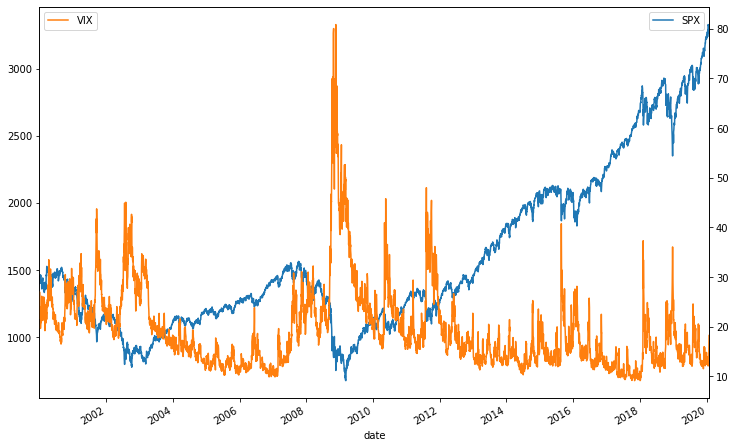

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize = (12, 8))

ax_spx = df['SPX'].plot()
ax_vix = df['VIX'].plot(secondary_y=True)

ax_spx.legend(loc=1)
ax_vix.legend(loc=2)

plt.show();

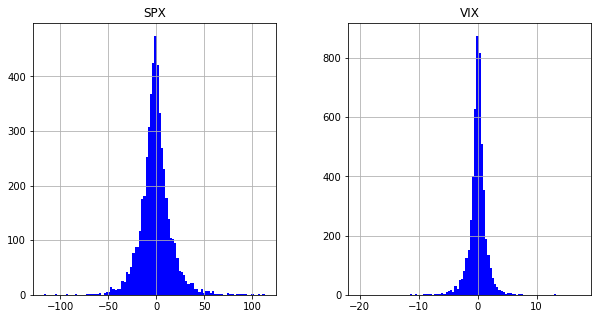

In [11]:
df.diff().hist(
    figsize=(10, 5),
    color='blue',
    bins=100);

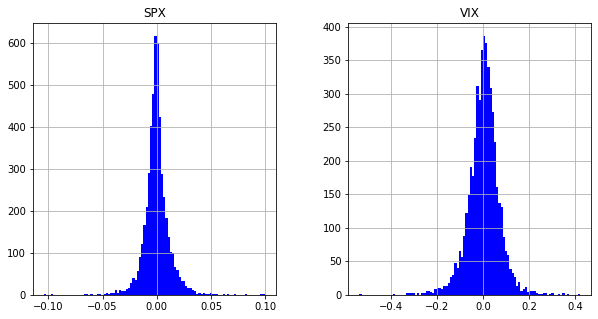

In [12]:
df.pct_change().hist(
    figsize=(10, 5),
     color='blue',
     bins=100);

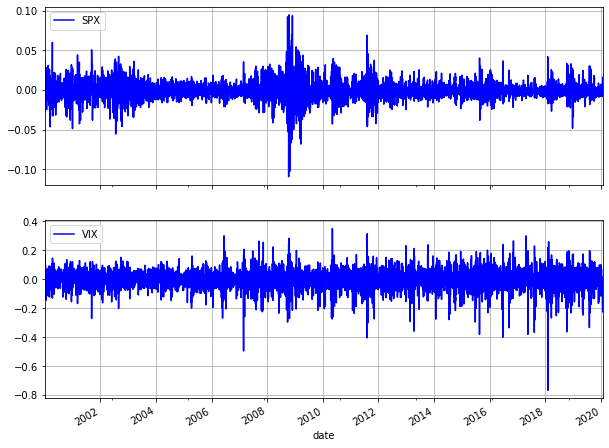

In [13]:
import numpy as np

log_returns = np.log(df / df.shift(1)).dropna()
log_returns.plot(
    subplots=True,
    figsize=(10, 8),
    color='blue',
    grid=True
);
for ax in plt.gcf().axes:
    ax.legend(loc='upper left')

## Correlation between SPX and VIX

In [14]:
log_returns.corr()

,SPX,VIX
SPX,1.000000,-0.733926
VIX,-0.733926,1.000000


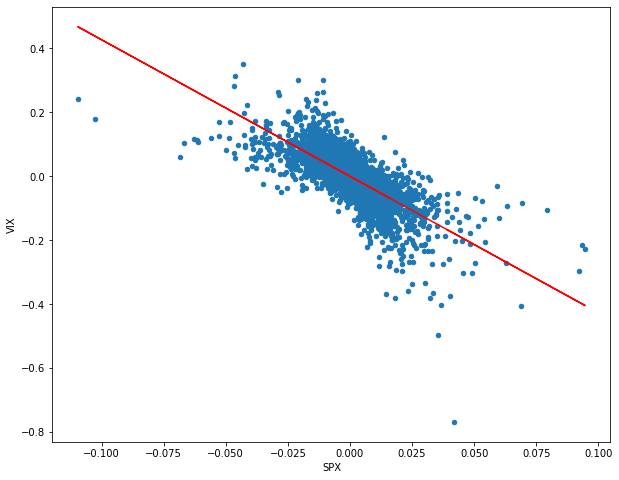

In [17]:
import statsmodels.api as sm

log_returns.plot(
    figsize=(10,8),
     x="SPX",
     y="VIX",
     kind='scatter')

ols_fit = sm.OLS(log_returns['VIX'].values,
log_returns['SPX'].values).fit()

plt.plot(log_returns['SPX'], ols_fit.fittedvalues, 'r');

In [16]:
pip install statsmodels

     |████████████████████████████████| 8.7MB 2.5MB/s eta 0:00:01
     |████████████████████████████████| 235kB 40.1MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


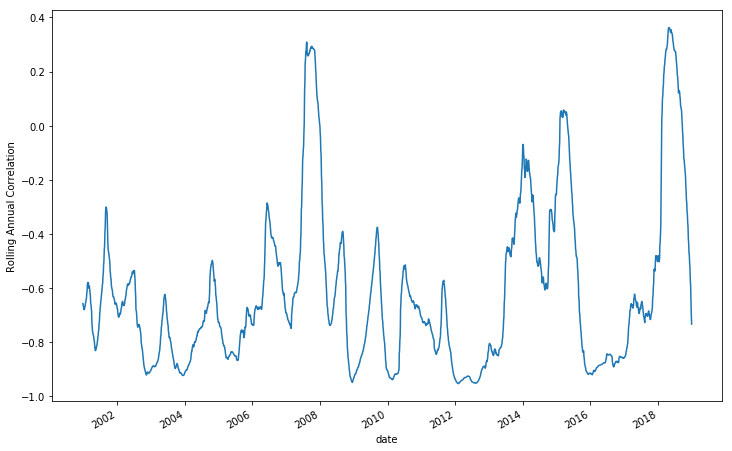

In [20]:
plt.ylabel('Rolling Annual Correlation')

df_corr = df['SPX'].rolling(252).corr(other=df['VIX'])
df_corr.plot(figsize=(12,8));

# Calculating the VIX index

In [18]:
import csv 

META_DATA_ROWS = 3  # Header data starts at line 4
COLS = 7  # Each option data occupy 7 columns

def read_file(filepath):
    meta_rows = []
    calls_and_puts = []

    with open(filepath, 'r') as file:
        reader = csv.reader(file)
        for row, cells in enumerate(reader):
            if row < META_DATA_ROWS:
                meta_rows.append(cells)
            else:
                call = cells[:COLS]
                put = cells[COLS:-1]

                calls_and_puts.append((call, put))                        

    return (meta_rows, calls_and_puts)

In [20]:
(meta_rows, calls_and_puts) = \
    read_file('SPX_EOD_2018_10_15.csv')

In [21]:
for line in meta_rows:
    print(line)

['SPX (S&P 500 INDEX)', '2750.79', '-16.34']
['Oct 15 2018 @ 20:00 ET']
['Calls', 'Last Sale', 'Net', 'Bid', 'Ask', 'Vol', 'Open Int', 'Puts', 'Last Sale', 'Net', 'Bid', 'Ask', 'Vol', 'Open Int']


In [22]:
from dateutil import parser

def get_dt_current(meta_rows):
    """
    Extracts time information.

    :param meta_rows: 2D array
    :return: parsed datetime object
    """
    # First cell of second row contains time info
    date_time_row = meta_rows[1][0]

    # Format text as ET time string
    current_time = date_time_row.strip()\
        .replace('@ ', '')\
        .replace('ET', '-05:00')\
        .replace(',', '')

    dt_current =  parser.parse(current_time)
    return dt_current

In [28]:
dt_current =  get_dt_current(meta_rows)
print(dt_current)

2018-10-15 20:00:00-05:00


In [23]:
for line in calls_and_puts[:2]:
    print(line)

(['2018 Oct 15 1700.00 (SPXW1815J1700)', '0.0', '0.0', '1039.30', '1063.00', '0', '0'], ['2018 Oct 15 1700.00 (SPXW1815V1700)', '0.15', '0.0', ' ', '0.05', '0'])
(['2018 Oct 15 1800.00 (SPXW1815J1800)', '0.0', '0.0', '939.40', '963.00', '0', '0'], ['2018 Oct 15 1800.00 (SPXW1815V1800)', '0.10', '0.0', ' ', '0.05', '0'])


In [30]:
from decimal import Decimal

def parse_expiry_and_strike(text):
    """
    Extracts information about the contract data.

    :param text: the string to parse.
    :return: a tuple of expiry date and strike price
    """
    # SPX Weeklys should expire at 3PM Chicago time.
    [year, month, day, strike, option_code] = text.split(' ')
    expiry = '%s %s %s 3:00PM -05:00' % (year, month, day)
    dt_object = parser.parse(expiry)    

    """
    Third friday SPX standard options expire at start of trading
    8.30 A.M. Chicago time.
    """
    if is_third_friday(dt_object):
        dt_object = dt_object.replace(hour=8, minute=30)

    strike = Decimal(strike)    
    return (dt_object, strike)

In [34]:
def is_third_friday(dt_object):
    return dt_object.weekday() == 4 and 15 <= dt_object.day <= 21

Testing our function with a simple contract code data and printing the results:

In [32]:
test_contract_code = '2018 Sep 26 1800.00 (*)'
(expiry, strike) = parse_expiry_and_strike(test_contract_code)

In [33]:
print('Expiry:', expiry)
print('Strike price:', strike)

Expiry: 2018-09-26 15:00:00-05:00
Strike price: 1800.00


This time round, let's test our function with a contract code data that falls on a third Friday.

In [35]:
test_contract_code = '2018 Oct 19 2555.00 (*)'
(expiry, strike) = parse_expiry_and_strike(test_contract_code)

In [37]:
print('Expiry:', expiry)
print('Strike price:', strike)

Expiry: 2018-10-19 08:30:00-05:00
Strike price: 2555.00


With our utility function in place, we can now go ahead and parse a single call or put option price entry, and return useful information which we can use:

In [38]:
def format_option_data(option_data):
    [desc, _, _, bid_str, ask_str] = option_data[:5]
    bid = Decimal(bid_str.strip() or '0')
    ask = Decimal(ask_str.strip() or '0')
    mid = (bid+ask) / Decimal(2)
    (expiry, strike) = parse_expiry_and_strike(desc)
    return (expiry, strike, bid, ask, mid)

## Finding near-term and next-term options

In [39]:
CALL_COLS = ['call_bid', 'call_ask', 'call_mid']
PUT_COLS = ['put_bid', 'put_ask', 'put_mid']
COLUMNS = CALL_COLS + PUT_COLS + ['diff']

In [40]:
import pandas as pd

def generate_options_chain(calls_and_puts):
    chain = {}

    for row in calls_and_puts:
        (call, put) = row

        (call_expiry, call_strike, call_bid, call_ask, call_mid) = \
            format_option_data(call)
        (put_expiry, put_strike, put_bid, put_ask, put_mid) = \
            format_option_data(put)

        # Ensure each line contains the same put and call maturity
        assert(call_expiry == put_expiry)

        # Get or create the DataFrame at the expiry
        df = chain.get(call_expiry, pd.DataFrame(columns=COLUMNS))

        df.loc[call_strike, CALL_COLS] = \
            [call_bid, call_ask, call_mid]
        df.loc[call_strike, PUT_COLS] = \
            [put_bid, put_ask, put_mid]
        df.loc[call_strike, 'diff'] = abs(put_mid-call_mid)

        chain[call_expiry] = df

    return chain

In [41]:
chain = generate_options_chain(calls_and_puts)

In [42]:
chain_keys = list(chain.keys())
for row in chain_keys[:2]:
    print(row)
print('...')
for row in chain_keys[-2:]:
    print(row)

2018-10-15 15:00:00-05:00
2018-10-17 15:00:00-05:00
...
2020-06-19 08:30:00-05:00
2020-12-18 08:30:00-05:00


In [43]:
def find_option_terms(chain, dt_current):
    """
    Find the near-term and next-term dates from
    the given indexes of the dictionary.

    :param chain: dictionary object
    :param dt_current: DateTime object of option quotes
    :return: tuple of 2 datetime objects
    """
    dt_near = None
    dt_next = None

    for dt_object in chain.keys():
        delta = dt_object - dt_current
        if delta.days > 23:
            # Skip non-fridays
            if dt_object.weekday() != 4:
                continue

            # Save the near term date
            if dt_near is None:
                dt_near = dt_object            
                continue

            # Save the next term date
            if dt_next is None:
                dt_next = dt_object            
                break

    return (dt_near, dt_next)

In [44]:
(dt_near, dt_next) = find_option_terms(chain, dt_current)

In [45]:
print('Found near-term maturity', dt_near, 
      'with', dt_near-dt_current, 'to expiry')
print('Found next-term maturity', dt_next, 
      'with', dt_next-dt_current, 'to expiry')

Found near-term maturity 2018-11-09 15:00:00-05:00 with 24 days, 19:00:00 to expiry
Found next-term maturity 2018-11-16 08:30:00-05:00 with 31 days, 12:30:00 to expiry


## Calculating the required minutes

In [47]:
dt_start_year = dt_current.replace(
    month=1, day=1, hour=0, minute=0, second=0)
dt_end_year = dt_start_year.replace(year=dt_current.year+1)

N_t1 = Decimal((dt_near-dt_current).total_seconds() // 60)
N_t2 = Decimal((dt_next-dt_current).total_seconds() // 60)
N_30 = Decimal(30 * 24 * 60)
N_365 = Decimal((dt_end_year-dt_start_year).total_seconds() // 60)

In [48]:
print('N_365:', N_365)
print('N_30:', N_30)
print('N_t1:', N_t1)
print('N_t2:', N_t2)

N_365: 525600
N_30: 43200
N_t1: 35700
N_t2: 45390


In [49]:
t1 = N_t1 / N_365
t2 = N_t2 / N_365

In [50]:
print('t1:%.5f'%t1)
print('t2:%.5f'%t2)

t1:0.06792
t2:0.08636


## Calculating the forward SPX index level

In [51]:
import math

def determine_forward_level(df, r, t):
    """
    Calculate the forward SPX index level.

    :param df: pandas DataFrame for a single option chain
    :param r: risk-free interest rate for t
    :param t: time to settlement in years
    :return: Decimal object
    """
    min_diff = min(df['diff'])
    pd_k = df[df['diff'] == min_diff]
    k = pd_k.index.values[0]

    call_price = pd_k.loc[k, 'call_mid']
    put_price = pd_k.loc[k, 'put_mid']
    return k + Decimal(math.exp(r*t))*(call_price-put_price)

In [52]:
r = Decimal(2.17/100)

In [53]:
df_near = chain.get(dt_near)
f1 = determine_forward_level(df_near, r, t1)

In [54]:
print('f1:', f1)

f1: 2747.596459994546094129930225


## Finding the required forward strike prices

In [55]:
def find_k0(df, f):
    return df[df.index<f].tail(1).index.values[0]

In [56]:
k0_near = find_k0(df_near, f1)

In [57]:
print('k0_near:', k0_near)

k0_near: 2745.00


## Determining strike price boundaries

In [60]:
def find_lower_and_upper_bounds(df, k0):
    """
    Find the lower and upper boundry strike prices.

    :param df: the pandas DataFrame of option chain
    :param k0: the forward strike price
    :return: a tuple of two Decimal objects
    """
    # Find lower bound
    otm_puts = df[df.index<k0].filter(['put_bid', 'put_ask'])
    k_lower = 0
    for i, k in enumerate(otm_puts.index[::-1][:-2]):
        k_lower = k
        put_bid_t1 = otm_puts.iloc[-i-1-1]['put_bid']
        put_bid_t2 = otm_puts.iloc[-i-1-2]['put_bid']
        if put_bid_t1 == 0 and put_bid_t2 == 0:
            break
        if put_bid_t2 == 0:
            k_lower = otm_puts.index[-i-1-1]

    # Find upper bound
    otm_calls = df[df.index>k0].filter(['call_bid', 'call_ask'])    
    k_upper = 0
    for i, k in enumerate(otm_calls.index[:-2]):
        call_bid_t1 = otm_calls.iloc[i+1]['call_bid']
        call_bid_t2 = otm_calls.iloc[i+2]['call_bid']
        if call_bid_t1 == 0 and call_bid_t2 == 0:
            k_upper = k
            break

    return (k_lower, k_upper)

In [62]:
(k_lower_near, k_upper_near) = \
    find_lower_and_upper_bounds(df_near, k0_near)

In [63]:
print(k_lower_near, k_upper_near)

1250.00 3040.00


## Tabulating contributions by strike prices

In [66]:
def calculate_contrib_by_strike(delta_k, k, r, t, q):
    return (delta_k / k**2)*Decimal(math.exp(r*t))*q

In [67]:
def find_prev_k(k, i, k_lower, df, bid_column):
    """
    Finds the strike price immediately below k 
    with non-zero bid.

    :param k: current strike price at i
    :param i: current index of df
    :param k_lower: lower strike price boundary of df
    :param bid_column: The column name that reads the bid price.
        Can be 'put_bid' or 'call_bid'.
    :return: strike price as Decimal object.
    """    
    if k <= k_lower:
        k_prev = df.index[i-1]
        return k_prev

    # Iterate backwards to find put bids           
    k_prev = 0
    prev_bid = 0
    steps = 1
    while prev_bid == 0:                                
        k_prev = df.index[i-steps]
        prev_bid = df.loc[k_prev][bid_column]
        steps += 1

    return k_prev

In [68]:
def find_next_k(k, i, k_upper, df, bid_column):
    """
    Finds the strike price immediately above k 
    with non-zero bid.

    :param k: current strike price at i
    :param i: current index of df
    :param k_upper: upper strike price boundary of df
    :param bid_column: The column name that reads the bid price.
        Can be 'put_bid' or 'call_bid'.
    :return: strike price as Decimal object.
    """    
    if k >= k_upper:
        k_next = df.index[i+1]
        return k_next

    k_next = 0
    next_bid = 0
    steps = 1
    while next_bid == 0:
        k_next = df.index[i+steps]
        next_bid = df.loc[k_next][bid_column]
        steps += 1

    return k_next

In [69]:
import pandas as pd

def tabulate_contrib_by_strike(df, k0, k_lower, k_upper, r, t):
    """
    Computes the contribution to the VIX index
    for every strike price in df.

    :param df: pandas DataFrame containing the option dataset
    :param k0: forward strike price index level
    :param k_lower: lower boundary strike price
    :param k_upper: upper boundary strike price
    :param r: the risk-free interest rate
    :param t: the time to expiry, in years
    :return: new pandas DataFrame with contributions by strike price
    """
    COLUMNS = ['Option Type', 'mid', 'contrib']
    pd_contrib = pd.DataFrame(columns=COLUMNS)

    for i, k in enumerate(df.index):
        mid, bid, bid_column = 0, 0, ''
        if k_lower <= k < k0:
            option_type = 'Put'
            bid_column = 'put_bid'
            mid = df.loc[k]['put_mid']
            bid = df.loc[k][bid_column]
        elif k == k0:
            option_type = 'atm'
        elif k0 < k <= k_upper:
            option_type = 'Call'
            bid_column = 'call_bid'
            mid = df.loc[k]['call_mid']
            bid = df.loc[k][bid_column]
        else:
            continue  # skip out-of-range strike prices

        if bid == 0:
            continue  # skip zero bids

        k_prev = find_prev_k(k, i, k_lower, df, bid_column)
        k_next = find_next_k(k, i, k_upper, df, bid_column)
        delta_k = Decimal((k_next-k_prev)/2)

        contrib = calculate_contrib_by_strike(delta_k, k, r, t, mid)
        pd_contrib.loc[k, COLUMNS] = [option_type, mid, contrib]

    return pd_contrib

In [70]:
pd_contrib_near = tabulate_contrib_by_strike(
    df_near, k0_near, k_lower_near, k_upper_near, r, t1)

In [71]:
pd_contrib_near.head()

,Option Type,mid,contrib
1250.00,Put,0.10,0.000003204720007271874493426366826
1300.00,Put,0.125,0.000003703679742131881579865901010
1350.00,Put,0.15,0.000004121296305647986745661479970
1400.00,Put,0.20,0.000005109566338124799893855814454
1450.00,Put,0.20,0.000004763258036967708819004706934


In [72]:
pd_contrib_near.tail()

,Option Type,mid,contrib
3020.00,Call,0.175,9.608028452572290489411343569E-8
3025.00,Call,0.225,1.231237623174939828257858985E-7
3030.00,Call,0.175,9.544713775211615220689389699E-8
3035.00,Call,0.20,1.087233242345573774601901086E-7
3040.00,Call,0.15,8.127448187590304540304760266E-8


## Calculating the volatilities

In [73]:
def calculate_volatility(pd_contrib, t, f, k0):
    """
    Calculate the volatility for a single-term option

    :param pd_contrib: pandas DataFrame containing 
        contributions by strike
    :param t: time to settlement of the option
    :param f: forward index level
    :param k0: immediate strike price below the forward level
    :return: volatility as Decimal object
    """
    term_1 = Decimal(2/t)*pd_contrib['contrib'].sum()
    term_2 = Decimal(1/t)*(f/k0 - 1)**2
    return term_1 - term_2

In [75]:
volatility_near = calculate_volatility(
    pd_contrib_near, t1, f1, k0_near)

In [76]:
print('volatility_near:', volatility_near)

volatility_near: 0.04891704334249740486501736967


## Calculating the next-term options

In [78]:
df_next = chain.get(dt_next)

f2 = determine_forward_level(df_next, r, t2)
k0_next = find_k0(df_next, f2)
(k_lower_next, k_upper_next) = \
    find_lower_and_upper_bounds(df_next, k0_next)
pd_contrib_next = tabulate_contrib_by_strike(
    df_next, k0_next, k_lower_next, k_upper_next, r, t2)
volatility_next = calculate_volatility(
    pd_contrib_next, t2, f2, k0_next)

## Calculating the VIX index

In [79]:
def calculate_vix_index(t1, volatility_1, t2, 
                        volatility_2, N_t1, N_t2, N_30, N_365):
    inner_term_1 = t1*Decimal(volatility_1)*(N_t2-N_30)/(N_t2-N_t1)
    inner_term_2 = t2*Decimal(volatility_2)*(N_30-N_t1)/(N_t2-N_t1)
    sqrt_terms = math.sqrt((inner_term_1+inner_term_2)*N_365/N_30)
    return 100 * sqrt_terms

In [80]:
vix = calculate_vix_index(
    t1, volatility_near, t2, 
    volatility_next, N_t1, N_t2, 
    N_30, N_365)

In [81]:
print('At', dt_current, 'the VIX is', vix)

At 2018-10-15 20:00:00-05:00 the VIX is 21.431114075693934


## Calculating multiple VIX indexes

In [82]:
    def process_file(filepath):
        """
        Reads the filepath and calculates the VIX index.

        :param filepath: path the options chain file
        :return: VIX index value
        """
        headers, calls_and_puts = read_file(filepath)    
        dt_current = get_dt_current(headers)

        chain = generate_options_chain(calls_and_puts)
        (dt_near, dt_next) = find_option_terms(chain, dt_current)

        N_t1 = Decimal((dt_near-dt_current).total_seconds() // 60)
        N_t2 = Decimal((dt_next-dt_current).total_seconds() // 60)
        t1 = N_t1 / N_365
        t2 = N_t2 / N_365

        # Process near-term options
        df_near = chain.get(dt_near)
        f1 = determine_forward_level(df_near, r, t1)
        k0_near = find_k0(df_near, f1)
        (k_lower_near, k_upper_near) = find_lower_and_upper_bounds(
            df_near, k0_near)
        pd_contrib_near = tabulate_contrib_by_strike(
            df_near, k0_near, k_lower_near, k_upper_near, r, t1)
        volatility_near = calculate_volatility(
            pd_contrib_near, t1, f1, k0_near)

        # Process next-term options
        df_next = chain.get(dt_next)
        f2 = determine_forward_level(df_next, r, t2)
        k0_next = find_k0(df_next, f2)
        (k_lower_next, k_upper_next) = find_lower_and_upper_bounds(
            df_next, k0_next)
        pd_contrib_next = tabulate_contrib_by_strike(
            df_next, k0_next, k_lower_next, k_upper_next, r, t2)
        volatility_next = calculate_volatility(
            pd_contrib_next, t2, f2, k0_next)

        vix = calculate_vix_index(
            t1, volatility_near, t2, 
            volatility_next, N_t1, N_t2, 
            N_30, N_365)

        return vix

In [83]:
FILE_DATES = [
    '2018_10_15',
    '2018_10_16',
    '2018_10_17',
    '2018_10_18',
    '2018_10_19',
]
FILE_PATH_PATTERN = 'files/chapter07/SPX_EOD_%s.csv'

In [84]:
pd_calcs = pd.DataFrame(columns=['VIX'])

for file_date in FILE_DATES:
    filepath = FILE_PATH_PATTERN % file_date

    vix = process_file(filepath)    
    date_obj = parser.parse(file_date.replace('_', '-'))

    pd_calcs.loc[date_obj, 'VIX'] = vix

In [85]:
pd_calcs.head(5)

,VIX
2018-10-15,21.4311
2018-10-16,17.7384
2018-10-17,17.4741
2018-10-18,20.0477
2018-10-19,19.9196


## Comparing the results

In [87]:
df_vix = df_vix_data['2018-10-14':'2018-10-21']['5. adjusted close']

In [88]:
df_vix.head(5)

date
2018-10-15    21.30
2018-10-16    17.62
2018-10-17    17.40
2018-10-18    20.06
2018-10-19    19.89
Name: 5. adjusted close, dtype: float64

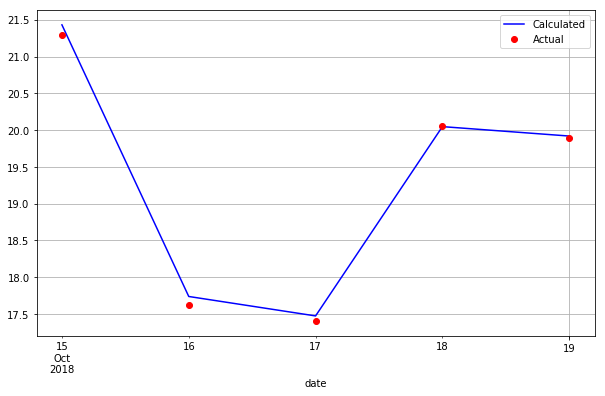

In [89]:
df_merged = pd.DataFrame({
    'Calculated': pd_calcs['VIX'],
    'Actual': df_vix,
})
df_merged.plot(figsize=(10, 6), grid=True, style=['b', 'ro']);